## Destiny Character Classifier Deep Learning
Credit to fastai's creators and available resources, as well as to paperspace for the distributed computing environment that made building this model possible

In [ ]:
from fastbook import *
from fastai.vision.widgets import *

In [ ]:
 
# Getting access to bing image search via an azure search key I have now for some reason
key = os.environ.get('AZURE_SEARCH_KEY', '864908d983de4805ada74b4ce2bb8c3f')

In [ ]:
results = search_images_bing(key, 'destiny 2 hunter')
ims = results.attrgot('contentUrl')
len(ims)

150

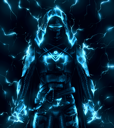

In [ ]:
# Creating a destination path to download the images 
dest = Path('images/destinycharss.jpg')
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)

In [ ]:
# Crawling for three different “char types” to classify between
char_types = 'hunter','warlock','titan'
path = Path('images/destinycharsss')
if not path.exists():
   path.mkdir()
   for o in char_types:
       dest = (path/o)
       dest.mkdir(exist_ok=True)
       results = search_images_bing(key, 'destiny 2' + f'{o}')
       download_images(dest, urls=results.attrgot('contentUrl'))
       [os.remove(path/o/file) for file in os.listdir(path/o) if file.endswith('.png')]

In [ ]:
# Checking to see what failed and removing it 
fns = get_image_files(path)
failed = verify_images(fns)
failed

(#8) [Path('images/destinycharsss/hunter/00000097.jpg'),Path('images/destinycharsss/hunter/00000010.jpg'),Path('images/destinycharsss/hunter/00000038.jpg'),Path('images/destinycharsss/hunter/00000095.jpg'),Path('images/destinycharsss/hunter/00000076.jpg'),Path('images/destinycharsss/warlock/00000136.jpg'),Path('images/destinycharsss/titan/00000079.jpg'),Path('images/destinycharsss/titan/00000026.jpg')]

In [ ]:
failed.map(Path.unlink);

In [ ]:
 
# Making a datablock out of all of the data we collected, telling it how to label and split, and then loading it 
chars = DataBlock(
   blocks=(ImageBlock, CategoryBlock),
   get_items=get_image_files,
   splitter=RandomSplitter(valid_pct=0.2, seed=42),
   get_y=parent_label,
   item_tfms=Resize(128))


In [ ]:
dls = chars.dataloaders(path)

In [ ]:
# Reusing data, since we only have 450 images 
chars = chars.new(
   item_tfms=RandomResizedCrop(224, min_scale=0.5),
   batch_tfms=aug_transforms())
dls = chars.dataloaders(path)


In [ ]:
learn = cnn_learner(dls, models.resnet18, metrics=error_rate)
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.876224,2.342175,0.532468,00:12


epoch,train_loss,valid_loss,error_rate,time
0,1.541086,1.507607,0.454545,00:12
1,1.443849,1.374251,0.454545,00:11
2,1.369332,1.494595,0.428571,00:12
3,1.220119,1.335292,0.389610,00:11
4,1.112231,1.251179,0.376623,00:12
5,1.014386,1.202563,0.376623,00:11


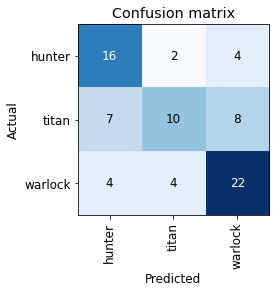

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


In [ ]:
path = Path()

In [ ]:
learn.export()
path.ls(file_exts='.pkl')
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('images/destinychar/hunter/00000000.jpg')

('hunter', TensorImage(0), TensorImage([9.5163e-01, 2.5628e-04, 4.8113e-02]))

In [ ]:
learn_inf.dls.vocab

['hunter', 'titan', 'warlock']

In [ ]:
btn_upload = widgets.FileUpload()
lbl_pred = widgets.Label()
btn_run = widgets.Button(description='Classify')
out_pl = widgets.Output()

In [ ]:
def on_click_classify(change):
   img = PILImage.create(btn_upload.data[-1])
   out_pl.clear_output()
   with out_pl: display(img.to_thumb(128,128))
   pred,pred_idx,probs = learn_inf.predict(img)
   lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
 
btn_run.on_click(on_click_classify)


## Local Dropdown to Upload Character File

In [ ]:
VBox([widgets.Label('Select your character!'),
     btn_upload, btn_run, out_pl, lbl_pred])